In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 20
import matplotlib.patches as mpatches

import settings_gfpkq  as st         # configuration file (update 2/June/22)
import helper as hp   
# Simple Gaussian process class adapted for the emulator
from gaussproc_emu import *

# Q-func post training x-check

In [2]:
root_dir =  "./"

In [3]:
if st.sigma8:
    #############
    # Load cosmological parameter sets
    # Omega_cdm h^2, Omega_b h^2, sigma8, ns, h
    ###########
    cosmologies = hp.load_arrays(root_dir + 'trainingset','cosmologies_sig8')
    tag="sigma8"
else:
    #############
    # Load cosmological parameter sets
    # Omega_cdm h^2, Omega_b h^2, ln10^10As, ns, h
    ###########
    cosmologies = hp.load_arrays(root_dir + 'trainingset', 'cosmologies_As')
    tag="As"

In [4]:
print(f"Cosmo[{tag}]: nber of training Cosmo points {cosmologies.shape[0]} for {cosmologies.shape[1]} params")

Cosmo[sigma8]: nber of training Cosmo points 1000 for 5 params


In [ ]:
#min/max of
# Omega_cdm h^2, Omega_b h^2, sigma8, ns, h    OR
# Omega_cdm h^2, Omega_b h^2, ln10^10As, ns, h

np.min(cosmologies,axis=0), np.max(cosmologies,axis=0)

In [5]:
print(f"Order of polynomial approx: {st.order}")
print(f"Whitening of x_train: {st.x_trans}")
print(f"Transformation of y_tain: {st.gf_args}")
print(f"outputs are centred on zero: {st.use_mean}")
print(f"noise covariance matrix: {st.var}")
print(f"Matrix diag term for stability: { st.jitter}")

Order of polynomial approx: 2
Whitening of x_train: True
Transformation of y_tain: {'y_trans': False, 'lambda_cap': 1}
outputs are centred on zero: False
noise covariance matrix: 1e-05
Matrix diag term for stability: 1e-05


In [6]:
#########
if st.sigma8:
    q_function = load_arrays(root_dir +'trainingset/components_sig8', 'q_function')
else:
    q_function = load_arrays(root_dir +'trainingset/components_As', 'q_function')

print(f"Q-func: nber of training points {q_function.shape[0]} for {q_function.shape[1]} z x k(lin,log)")
n_qf = q_function.shape[1]
assert n_qf == st.nk * st.nz, "Hummm something strange..."
print(f"The number of GPs to model Q-func={n_qf}")

if  st.sigma8:
    folder_qf = root_dir + '/pknl_components' + st.d_one_plus +'_sig8' + '/qf'
else:
    folder_qf = root_dir + '/pknl_components' + st.d_one_plus +'_As' + '/qf'
    
if st.emu_one_plus_q:
    arg_qf = [[cosmologies, 1.0 + q_function[:, i], st.qf_args, folder_qf, 'gp_' + str(i)] for i in range(n_qf)]
else:
    arg_qf = [[cosmologies, q_function[:, i], st.qf_args, folder_qf, 'gp_' + str(i)] for i in range(n_qf)]


Q-func: nber of training points 1000 for 800 z x k(lin,log)
The number of GPs to model Q-func=800


# Post training : (emu_i(theta_j) - y_ij)/y_ij

2022-06-03 09:16:16.623663: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:404] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[5,1000]{1,0} custom-call(f64[5,5]{1,0} %Arg_0.1, f64[5,1000]{1,0} %Arg_1.2), custom_call_target="__cublas$gemm", metadata={op_name="jit(dot)/jit(main)/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/sps/lsst/users/campagne/Jemu/transformation.py" source_line=94}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]}}" failed. Falling back to default algorithm.  Per-algorithm errors:
2022-06-03 09:16:17.537277: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:404] Failed

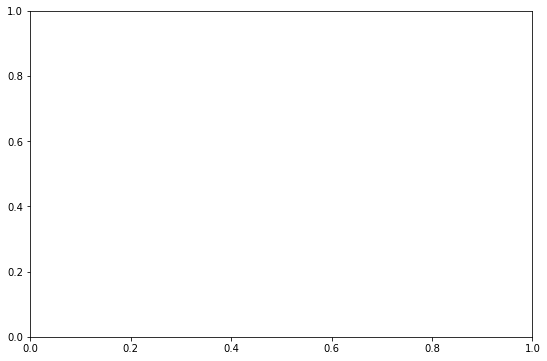

In [7]:
fig, ax = plt.subplots(figsize=(9,6))

first = True

medians = []
means = []
sigmas = []


for i_qf in range(n_qf):
    # for the time beeing re-instance the class each time
    gp_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.qf_args['y_trans'],          ######
                         use_mean=st.use_mean)
    
    #print(f"Process GP_{i_qf}/{n_qf}")

    theta = arg_qf[i_qf][0] # cosmo \Theta_i i<N_train
    y = arg_qf[i_qf][1]     # Q((z,k)j,\Theta_i)
    arg_cur_gp = arg_qf[i_qf][2]
    arg_cur_gp["folder_name"] = arg_qf[i_qf][3]
    arg_cur_gp["file_name"] = arg_qf[i_qf][4]

    #load training 
    gp_model.load_info(arg_cur_gp["folder_name"],arg_cur_gp["file_name"])
#    print(f"GP_{i_gf}",gp_model.mean_theta, gp_model.x_trans, gp_model.transform.mu_matrix,
#          gp_model.kernel_hat, gp_model.beta_hat, gp_model.kinv_XX_res[:10],
#          gp_model.mean_function, gp_model.x_train[:10])
    
    diff = (gp_model.pred_original_function(theta)-y)/y
    
#    print('diff:',diff)
    
    medians.append(np.median(diff))
    means.append(np.mean(diff))
    sigmas.append(np.std(diff))
    
#    if first:
#        _,bins,_ = ax.hist(np.array(diff),bins=75, density=False, histtype='step',
#                            range=[-3e-2,3e-2],label=f'JAX_GP_{i_qf}');
#        first = False
#    else:
#        ax.hist(np.array(diff),bins=bins, density=False, histtype='step',
#                            range=[-3e-2,3e-2],label=f'JAX_GP_{i_qf}');
        
    
#ax.legend(loc='upper left', fontsize=10)
#ax.set_xlabel(r"$(y_{pred}-y_{train})/y_{train}$");
#ax.set_ylabel('prob.')    
#fig.suptitle(r"After optim. $y=Pk_{lin}(k_i,\theta_j)$ (all i and j)");

In [10]:
medians=np.array(medians)
sigmas=np.array(sigmas)

In [18]:
means=np.array(means)

In [11]:
medians.shape

(800,)

In [12]:
#ks=np.linspace(st.k, st.zmax, st.nz, endpoint=True)
idx = np.linspace(1,st.nz*st.nk, st.nz*st.nk, endpoint=True)

In [13]:
idx.shape, medians.shape

((800,), (800,))

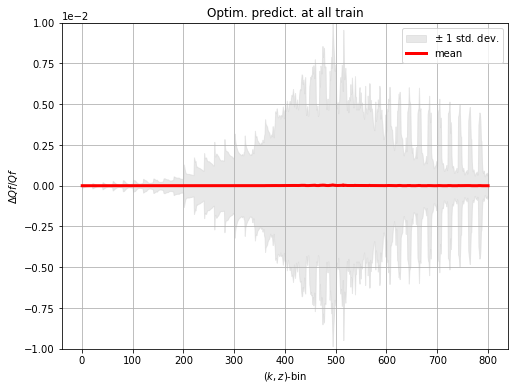

In [14]:
n_sig=1
plt.figure(figsize=(8,6))
plt.fill_between(idx,means-n_sig*sigmas,means+n_sig*sigmas, color="lightgray", 
                 label=fr"$\pm$ {n_sig} std. dev.", alpha=0.5)
plt.plot(idx,means,c='red', lw=3,label='mean')


plt.legend()
plt.xlabel(r"$(k,z)$-bin")
#plt.xscale("log")
plt.ylabel(r"$\Delta Qf/Qf$")
plt.ylim([-1e-2,1e-2])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.grid()
plt.title("Optim. predict. at all train");

In [15]:
medians.shape, sigmas.shape

((800,), (800,))

In [16]:
medians=medians.reshape((st.nk,st.nz))
sigmas=sigmas.reshape((st.nk,st.nz))

In [19]:
means=means.reshape((st.nk,st.nz))

In [25]:
ks = np.geomspace(st.k_min_h_by_Mpc, st.kmax, st.nk, endpoint=True)

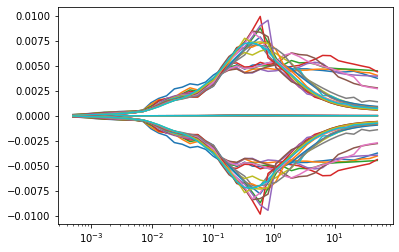

In [28]:
plt.plot(ks,means,label='mean');
plt.plot(ks,means+sigmas);
plt.plot(ks,means-sigmas);
plt.xscale("log")